# Import bibliotek

In [27]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
import numpy as np

from ucimlrepo import fetch_ucirepo


# Przeprocesowanie zbioru danych

In [35]:
heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features
Y = heart_disease.data.targets

Y = Y['num'].replace([1, 2, 3, 4], 1)

X['num'] = Y

median = X['ca'].median()
X['ca'].fillna(median, inplace=True)
mode_category = X['thal'].mode()[0]
X['thal'].fillna(mode_category, inplace=True)


In [36]:
def one_hot_encode(df, column, column_names):
    dummies = pd.get_dummies(df[column], prefix=column)
    column_names = [column + '_' + str(name) for name in column_names]
    dummies.columns = column_names
    dummies = dummies.astype('int64')
    df = pd.concat([df, dummies], axis=1)
    df.drop(column, axis=1, inplace=True)
    return df

In [37]:
X =  one_hot_encode(X, 'cp', ['typical_angina', 'atypical_angina', 'non-anginal_pain', 'asymptomatic'])
X = one_hot_encode(X, 'thal', ['normal', 'ST-T_wave_abnormality', 'left_ventricular_hypertrophy'])
X = one_hot_encode(X, 'slope', ['upsloping', 'flat', 'downsloping'])
X = one_hot_encode(X, 'restecg', ['normal', 'fixed_defect', 'reversable_defect'])

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                303 non-null    int64  
 1   sex                                303 non-null    int64  
 2   trestbps                           303 non-null    int64  
 3   chol                               303 non-null    int64  
 4   fbs                                303 non-null    int64  
 5   thalach                            303 non-null    int64  
 6   exang                              303 non-null    int64  
 7   oldpeak                            303 non-null    float64
 8   ca                                 303 non-null    float64
 9   num                                303 non-null    int64  
 10  cp_typical_angina                  303 non-null    int64  
 11  cp_atypical_angina                 303 non-null    int64  

In [39]:
X.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,...,cp_asymptomatic,thal_normal,thal_ST-T_wave_abnormality,thal_left_ventricular_hypertrophy,slope_upsloping,slope_flat,slope_downsloping,restecg_normal,restecg_fixed_defect,restecg_reversable_defect
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,131.689769,246.693069,0.148515,149.607261,0.326733,1.039604,0.663366,0.458746,...,0.475248,0.554455,0.059406,0.386139,0.468647,0.462046,0.069307,0.498350,0.013201,0.488449
std,9.038662,0.467299,17.599748,51.776918,0.356198,22.875003,0.469794,1.161075,0.934375,0.499120,...,0.500213,0.497848,0.236774,0.487668,0.499842,0.499382,0.254395,0.500824,0.114325,0.500693
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,241.000000,0.000000,153.000000,0.000000,0.800000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,166.000000,1.000000,1.600000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [40]:

Y = X['num']
X = X.drop('num', axis=1)

pd.set_option('display.width', 2000)
X_norm = (X - X.min()) / (X.max() - X.min())
X_norm.describe()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_typical_angina,...,cp_asymptomatic,thal_normal,thal_ST-T_wave_abnormality,thal_left_ventricular_hypertrophy,slope_upsloping,slope_flat,slope_downsloping,restecg_normal,restecg_fixed_defect,restecg_reversable_defect
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.529978,0.679868,0.355564,0.275555,0.148515,0.600055,0.326733,0.167678,0.221122,0.075908,...,0.475248,0.554455,0.059406,0.386139,0.468647,0.462046,0.069307,0.498350,0.013201,0.488449
std,0.188305,0.467299,0.166035,0.118212,0.356198,0.174618,0.469794,0.187270,0.311458,0.265288,...,0.500213,0.497848,0.236774,0.487668,0.499842,0.499382,0.254395,0.500824,0.114325,0.500693
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.245283,0.194064,0.000000,0.477099,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,0.339623,0.262557,0.000000,0.625954,0.000000,0.129032,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,1.000000,0.433962,0.340183,0.000000,0.725191,1.000000,0.258065,0.333333,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
class Neuron():
    def __init__(self, num_of_weights, stand_dev=1):
        self.weights = np.random.normal(scale=stand_dev, size=num_of_weights)
        self.bias = np.random.normal(scale=stand_dev)
        self.X = None
        self.derivative = None

    @staticmethod
    def sigmoid(X):
        # return np.exp(-np.logaddexp(0, -X))
        return 1 / (1 + np.exp(-X))

    def sigmoid_derivative(self, X):
        return self.sigmoid(X) * (1 - self.sigmoid(X))

    def forward(self, inputs):
        self.X = inputs
        return self.sigmoid(np.dot(inputs, self.weights) + self.bias)

    def backward(self, error, weights_next_layer=None):
        if weights_next_layer is not None:
            error = error.T @ weights_next_layer
        self.derivative = error * self.sigmoid_derivative(np.dot(self.X,self.weights) + self.bias)
        return self.derivative
    
    def update(self, learning_rate):
        self.weights -=  learning_rate * np.dot(self.X.T, self.derivative)
        self.bias -= learning_rate * np.sum(self.derivative)
        self.X = None
        self.derivative = None

class NeuralNetwork():
    def __init__(self, num_of_inputs, hidden_layers, num_of_outputs, stand_dev=1.0):
        self.layers = []
        self.num_of_inputs = num_of_inputs
        self.hidden_layers = hidden_layers
        self.num_of_outputs = num_of_outputs
        self.num_of_hidden_layers = len(hidden_layers)
        self.stand_dev = stand_dev
        
        self.layers.append([Neuron(num_of_inputs, self.stand_dev) for _ in range(hidden_layers[0])])
        for i in range(1, self.num_of_hidden_layers):
            self.layers.append([Neuron(hidden_layers[i-1], self.stand_dev) for _ in range(hidden_layers[i])])
        if self.num_of_outputs == 1:
            self.layers.append([Neuron(hidden_layers[-1], self.stand_dev)])

    def cross_entropy(self, y, y_pred):
        return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis=1)

    def cross_entropy_derivative(self, y, y_pred):
        return -np.sum(y / y_pred - (1 - y) / (1 - y_pred), axis=1)

    def forward(self, X):
        for layer in self.layers:
            X = np.array([neuron.forward(X) for neuron in layer]).T
        return X        

    def backward(self, output_error):
        # Iterate over the hidden layers in reverse order and calculate their gradients
        output_layer = self.layers[-1]
        output_error = np.array([neuron.backward(output_error) for neuron in output_layer])
        weights_next_layer = np.array([neuron.weights for neuron in output_layer]).T

        for layer in reversed(self.layers[:-1]):
            output_error = np.array([neuron.backward(output_error, weights_next_layer[index]) for index, neuron in enumerate(layer)])
            weights_next_layer = np.array([neuron.weights for neuron in layer]).T
        
        # Return the final gradients
        return output_error

    def update(self, learning_rate):
        for layer in self.layers:
            for neuron in layer:
                neuron.update(learning_rate)

    def fit(self, X, y, epochs=1000, batch_size=10, learning_rate=0.005):
        n_samples, n_features = X.shape
        # Jeśli batch_size jest większy niż liczba próbek, to ustawiamy go na liczbę próbek -> zwyczajnie uczymy na całym zbiorze GD
        if batch_size > n_samples:
            batch_size = n_samples
        cost_list = []
        for epoch in range(epochs):
            random_order = np.random.permutation(n_samples)
            X_shuffled = X.values[random_order]
            y_shuffled = y.values[random_order]
            # lista kosztów w paczkach dla każdej epoki
            cost_list_in_batch = []

            for batch_index in range(0, n_samples, batch_size):

                X_batch = X_shuffled[batch_index:batch_index + batch_size]
                y_batch = y_shuffled[batch_index:batch_index + batch_size].reshape(-1, 1)
                predictions = self.forward(X_batch)
                output_error = self.cross_entropy_derivative(y_batch, predictions)
                self.backward(output_error)
                self.update(learning_rate)
                
            cost = self.cross_entropy(y_batch, predictions)
            cost_list.append(np.mean(cost))

            if epoch % (epochs // 8) == 0:
                print(f'Epoch: {epoch}, Loss: {np.mean(cost)}')

            # self.cost_list.append(cost)
            # iteration_cost = np.mean(cost_list_in_batch)
            # self.mean_cost_list.append(iteration_cost)
            # self.epoch_list.append(i)
        print(f'Epoch: {epoch}, Loss: {np.mean(cost)}')
        return self, cost_list


    def predict(self, X):
        return self.forward(X)

# Implementacja Sieci Neuronowej

In [7]:
def sigmoid(X):
    return np.exp(-np.logaddexp(0, -X))

def sigmoid_derivative(X):
    return sigmoid(X) * (1 - sigmoid(X))

def cross_entropy(y, y_pred):
    return -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis=1)

def cross_entropy_derivative(y, y_pred):
    return -np.sum(y / y_pred - (1 - y) / (1 - y_pred), axis=1)

class Neuron():
    def __init__(self, num_of_weights, activation_function, activation_derivative, stand_dev=1):
        self.weights = np.random.normal(scale=stand_dev, size=num_of_weights)
        self.bias = np.random.normal(scale=stand_dev)
        self.X = None
        self.derivative = None
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative

    def forward(self, inputs):
        self.X = inputs
        return self.activation_function(np.dot(inputs, self.weights) + self.bias)

    def backward(self, error, weights_next_layer=None):
        if weights_next_layer is not None:
            error = error.T @ weights_next_layer
        self.derivative = error * self.activation_derivative(np.dot(self.X, self.weights) + self.bias)
        return self.derivative

    def update(self, learning_rate):
        self.weights -= learning_rate * np.dot(self.X.T, self.derivative)
        self.bias -= learning_rate * np.sum(self.derivative)
        self.X = None
        self.derivative = None



class NeuralNetwork():
    def __init__(self, num_of_inputs, hidden_layers, num_of_outputs, activation_function = sigmoid, activation_derivative = sigmoid_derivative, loss_function = cross_entropy, loss_derivative = cross_entropy_derivative, stand_dev=1.0):
        self.layers = []
        self.num_of_inputs = num_of_inputs
        self.hidden_layers = hidden_layers
        self.num_of_outputs = num_of_outputs
        self.num_of_hidden_layers = len(hidden_layers)
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative
        self.loss_function = loss_function
        self.loss_derivative = loss_derivative
        self.stand_dev = stand_dev

        self.layers.append([Neuron(num_of_inputs, activation_function, activation_derivative, self.stand_dev) for _ in range(hidden_layers[0])])
        for i in range(1, self.num_of_hidden_layers):
            self.layers.append([Neuron(hidden_layers[i-1], activation_function, activation_derivative, self.stand_dev) for _ in range(hidden_layers[i])])
        if self.num_of_outputs == 1:
            self.layers.append([Neuron(hidden_layers[-1], activation_function, activation_derivative, self.stand_dev)])

    def forward(self, X):
        for layer in self.layers:
            X = np.array([neuron.forward(X) for neuron in layer]).T
        return X

    def backward(self, output_error):
        output_layer = self.layers[-1]
        output_error = np.array([neuron.backward(output_error) for neuron in output_layer])
        weights_next_layer = np.array([neuron.weights for neuron in output_layer]).T

        for layer in reversed(self.layers[:-1]):
            output_error = np.array([neuron.backward(output_error, weights_next_layer[index]) for index, neuron in enumerate(layer)])
            weights_next_layer = np.array([neuron.weights for neuron in layer]).T

        return output_error

    def update(self, learning_rate):
        for layer in self.layers:
            for neuron in layer:
                neuron.update(learning_rate)

    def fit(self, X, y, X_test, Y_test, epochs=1000, batch_size=20, learning_rate=0.001):
        n_samples, n_features = X.shape
        if batch_size > n_samples:
            batch_size = n_samples
        train_cost_list = []
        iteration_train_cost = []
        mean_train_cost_list = []

        test_cost_list = []
        iteration_test_cost = []
        mean_test_cost_list = []

        for epoch in range(epochs):
            random_order = np.random.permutation(n_samples)
            X_shuffled = X.values[random_order]
            y_shuffled = y.values[random_order]

            train_cost_list_in_batch = []
            test_cost_list_in_batch = []

            for batch_index in range(0, n_samples, batch_size):
                X_batch = X_shuffled[batch_index:batch_index + batch_size]
                y_batch = y_shuffled[batch_index:batch_index + batch_size].reshape(-1, 1)
                predictions = self.forward(X_batch)
                output_error = self.loss_derivative(y_batch, predictions)
                self.backward(output_error)
                self.update(learning_rate)
                

                train_cost = np.mean(self.loss_function(y_batch, predictions))
                train_cost_list_in_batch.append(train_cost)
                

                test_predictions = self.predict(X_test)
                test_cost = np.mean(self.loss_function(Y_test.values.reshape(-1, 1), test_predictions))
                test_cost_list_in_batch.append(test_cost)
                

            train_cost_list.append(train_cost)
            iteration_train_cost = np.mean(train_cost_list_in_batch)
            mean_train_cost_list.append(iteration_train_cost)

            test_cost_list.append(test_cost)
            iteration_test_cost = np.mean(test_cost_list_in_batch)
            mean_test_cost_list.append(iteration_test_cost)

            if epoch % (epochs // 8) == 0:
                print(f'Epoch: {epoch}, Loss: {train_cost}')

        print(f'Epoch: {epoch}, Loss: {train_cost}')
        return self, train_cost_list, mean_train_cost_list, test_cost_list

    def predict(self, X):
        return self.forward(X)




Na samym początku zdefiniowałem potrzebną funkcję aktywacji oraz jej pochodną.

- `sigmoid(x)` - stabilnie numeryczna funkcja sigmoidalna
- `sigmoid_derivative(x)` - pochodna funkcji sigmoidalnej

Oraz funkcję liczenia kosztu:
- `cross_entropy(y, y_pred)` - funkcja kosztu
- `cross_entropy_derivative(y, y_pred)` - pochodna funkcji kosztu



Klasa `Neuron` reprezentuje pojedynczy neuron w sieci neuronowej. Przyjmuje następujące parametry podczas inicjalizacji:

- `num_of_weights`: Liczba wag (parametrów) neuronu.
- `activation_function`: Funkcja aktywacji neuronu. Przekazana przez parametr. Domyślnie funkcja sigmoidalna.
- `activation_derivative`: Pochodna funkcji aktywacji neuronu. Przekazana przez parametr. Domyślnie pochodna funkcji sigmoidalnej.
- `stand_dev`: Odchylenie standardowe używane do inicjalizacji wag neuronu (domyślnie 1).


Metody klasy Neuron obejmują:
- `forward(self, inputs)` - wykonuje krok przód, zapisuje wejście (macierz) do propagacji wstcznej, oblicza wyjście neuronu na podstawie wejścia i funkcji aktywacji.
- `backward(self, error, weights_next_layer=None)` - wykonuje krok wstecz, oblicza pochodną błędu względem wejścia neuronu. Przyjmuje macierz gradientów z wartswy następnej. Dla warstwy wyjściowej przyjmuje błąd wyjściowy. Zwraca macierz gradientów dla warstwy poprzedniej. Jeżeli przyjmuje wagi warstwy następnej to obliczany jest sumę ilocznu wag i gradientów z warstwy następnej, potem zwracamy macierz pochodnych funkcji kosztu.
- `update(self, learning_rate)` - aktualizuje wagi oraz bias neuronu na podstawie gradientów funkcji kosztu dla każdej z wag i współczynnika uczenia. Przechodzimy po wszystkich wagach i aktualizujemy je.


Klasa `NeuralNetwork` reprezentuje sieć neuronową. Przyjmuje następujące parametry podczas inicjalizacji:
- `num_of_inputs`: Liczba wejść sieci.
- `hidden_layers`: Lista zawierająca liczbę neuronów w każdej z warstw ukrytych.
- `num_of_outputs`: Liczba wyjść sieci.
- `activation_function`: Funkcja aktywacji uzywana w neuronach sieci. 
- `activattion_deerivative`: Pochodna funkcji aktywacji.
- `loss_function`:  Funkcja kosztu sieci.
- `loss_derivative`: Pochodna funkcji kosztu sieci.
- `stand_dev`: Odchylenie standardowe przy inicjacji wag neuronów w warstwach sieci.

Metody klasy NeuralNetwork obejmują:

- `forward(self, inputs)`: Wykonuje krok przód, obliczając wyjście neuronu na podstawie wejścia i funkcji aktywacji. Przyjmuje na wejsciu macierz wejść sieci czyli danych, wyniki przekazuje jako macierz wyjść, które są wejściem dla kolejnej warstwy, tak do momentu aż dojdziemy do ostatniej warstwy, która zwraca wynik.
- `backward(self, error, weights_next_layer=None)`: Wykonuje krok wstecz, obliczając pochodną błędu względem wejścia neuronu. Jeśli - dostępne są wagi warstwy następnej, można je przekazać, aby obliczyć błąd wsteczny w oparciu o te wagi. W przypadku ostaniej warstwy wyjściowej nie mamy wag następnej warstwy, więc przekazujemy None. Wtedy obliczamy błąd wsteczny na podstawie błędu wyjściowego, który jest przekazany jako parametr.
- `update(self, learning_rate)`: Aktualizuje wagi oraz bias neuronu na podstawie pochodnej błędu i współczynnika uczenia. Czynność wykonuje się przez wszystkie neurony w warstwie. Przechodzimy po wszystkich warstwach. Przyjmuje jako parametr współczynnik uczenia.
- `fit(self, X, y, epochs=1000, batch_size=10, learning_rate=0.005)` - funkcja przeprowadzająca procedure nauki modelu. Przyjmuje:
    - `X`
    - `y`
    - `epochs`
    - `batch_size`
    - `learning_rate`
    Metoda w ramach każdej epoki oraz batcha wykonuje `forward`, obliczenie kosztu, `backward`, oraz `update`.

- `predict(self, X)` - na wejściu przyjmuj macierz wejść do sieci, zwraca wynik wywnioskowany przez sieć



# Badanie zahchowania modelu od jego ustawień

Epoch: 0, Loss: 1.1589117283340982
Epoch: 125, Loss: 0.34665211886230674
Epoch: 250, Loss: 0.18432877550783902
Epoch: 375, Loss: 0.2918395232619555
Epoch: 500, Loss: 0.6832561253369368
Epoch: 625, Loss: 0.16838083070146798
Epoch: 750, Loss: 0.3302580332039848
Epoch: 875, Loss: 0.8253237052162712
Epoch: 999, Loss: 0.27561153258563653
Accuracy: 0.9016393442622951
Precision: 0.8823529411764706
Recall: 0.9375
F1: 0.9090909090909091


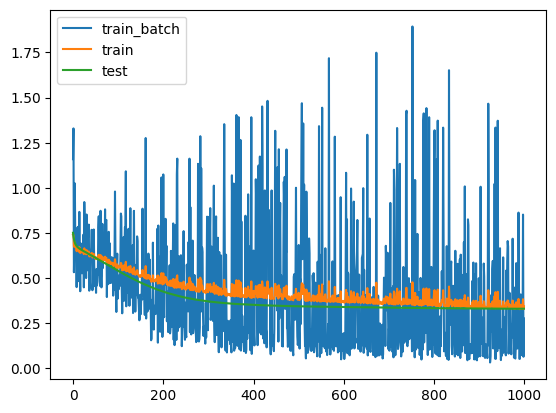

In [10]:
seed = 42
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y, test_size=0.2)
mlp = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=[8, 4], num_of_outputs=1)
model, train_hist_batch, train_hist, test_hist = mlp.fit(X_train, Y_train, X_test, Y_test)
predictions = mlp.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(f'Accuracy: {accuracy_score(Y_test, predictions)}')
print(f'Precision: {precision_score(Y_test, predictions)}')
print(f'Recall: {recall_score(Y_test, predictions)}')
print(f'F1: {f1_score(Y_test, predictions)}')

import matplotlib.pyplot as plt
plt.plot(train_hist_batch, label='train_batch')
plt.plot(train_hist, label='train')
plt.plot(test_hist, label='test')
plt.legend()
plt.show()



Epoch: 0, Loss: 0.7375164934262693
Epoch: 125, Loss: 0.6798161321432433
Epoch: 250, Loss: 0.19920743178405348
Epoch: 375, Loss: 0.42726453564112404
Epoch: 500, Loss: 0.0379616023724316
Epoch: 625, Loss: 0.062493586969126505
Epoch: 750, Loss: 0.379328279383851
Epoch: 875, Loss: 0.07284800785799798
Epoch: 999, Loss: 0.02264275457285306
Accuracy: 0.8
Precision: 0.7307692307692307
F1: 0.76


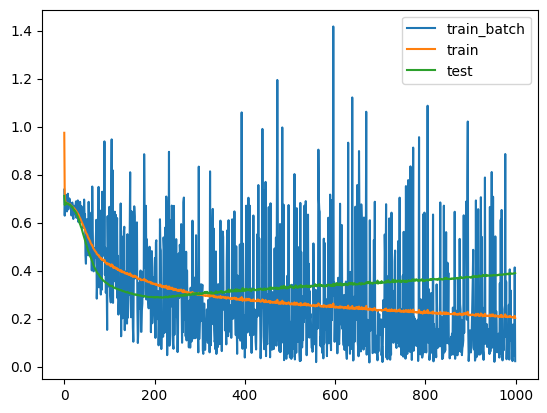

In [37]:
dim_hidd_1 = [5, 5]
dim_hidd_1_nn = NeuralNetwork(X_train.shape[1], dim_hidd_1, 1)
model, train_hist_batch, train_hist, test_hist =  dim_hidd_1_nn.fit(X_train, Y_train, X_test, Y_test)

predictions = dim_hidd_1_nn.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(f'Accuracy: {accuracy_score(Y_test, predictions)}')
print(f'Precision: {precision_score(Y_test, predictions)}')
print(f'F1: {f1_score(Y_test, predictions)}')

import matplotlib.pyplot as plt
plt.plot(train_hist_batch, label='train_batch')
plt.plot(train_hist, label='train')
plt.plot(test_hist, label='test')
plt.legend()
plt.show()

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X_norm, Y, test_size=0.2, random_state=seed)

# domyślna sieć
default_hidden_layers = [10, 5]

#1.Różnej wymiarowości warstwy ukrytej
dim_hidd_1 = [5, 5]
dim_hidd_2 = [20, 10]
dim_hidd_3 = [50, 25]
#2. Różnej wartości współczynnika uczenia
learning_rate_1 = 0.001
learning_rate_2 = 0.01
#3. Różnej wartości parametru standaryzacji
stand_dev_1 = 0.1
stand_dev_2 = 5
#4.danych znormalizownaych i nieznormalizowanych
unnorm = X_train, Y_train
#5. Różnej liczby watstw ukrytych
hidden_layers_size_1 = [10]
hidden_layers_size_2 = [10,5,2]
hidden_layers_size_3 = [10,5,3,2]

default_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1)
dim_hidd_1_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=dim_hidd_1, num_of_outputs=1)
dim_hidd_2_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=dim_hidd_2, num_of_outputs=1)
dim_hidd_3_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=dim_hidd_3, num_of_outputs=1)
learning_rate_1_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1)
learning_rate_2_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1)
stand_dev_1_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1, stand_dev=stand_dev_1)
stand_dev_2_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1, stand_dev=stand_dev_2)
unnorm_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=default_hidden_layers, num_of_outputs=1)
hidden_layers_size_1_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=hidden_layers_size_1, num_of_outputs=1)
hidden_layers_size_2_nn = NeuralNetwork(num_of_inputs=X_train.shape[1], hidden_layers=hidden_layers_size_2, num_of_outputs=1)

print('Default')
default_mlp, loss_history_1 = default_nn.fit(X_train, Y_train)
print('----------------')
print('Dim hidd 1')
dim_hidd_1_mlp, loss_history_2 = dim_hidd_1_nn.fit(X_train, Y_train)
print('----------------')
print('Dim hidd 2')
dim_hidd_2_mlp, loss_history_3 = dim_hidd_2_nn.fit(X_train, Y_train)
print('----------------')
print('Dim hidd 3')
dim_hidd_3_mlp, loss_history_4 = dim_hidd_3_nn.fit(X_train, Y_train)
print('----------------')
print('Learning rate 1')
learning_rate_1_mlp, loss_history_5 = learning_rate_1_nn.fit(X_train, Y_train, learning_rate=learning_rate_1)
print('----------------')
print('Learning rate 2')
learning_rate_2_mlp, loss_history_6 = learning_rate_2_nn.fit(X_train, Y_train, learning_rate=learning_rate_2)
print('----------------')
print('Stand dev 1')
stand_dev_1_mlp, loss_history_7 = stand_dev_1_nn.fit(X_train, Y_train)
print('----------------')
print('Stand dev 2')
stand_dev_2_mlp, loss_history_8 = stand_dev_2_nn.fit(X_train, Y_train)
print('----------------')
print('Unnorm')
unnorm_mlp, loss_history_9 = unnorm_nn.fit(X_train_n, Y_train_n)
print('----------------')
print('Hidden layers size 1')
hidden_layers_size_1_mlp, loss_history_10 = hidden_layers_size_1_nn.fit(X_train, Y_train)
print('----------------')
print('Hidden layers size 2')
hidden_layers_size_2_mlp, loss_history_11 = hidden_layers_size_2_nn.fit(X_train, Y_train)
print('----------------')


Default
Epoch: 0, Loss: 0.7524962040592994
Epoch: 125, Loss: 0.7009894242599631
Epoch: 250, Loss: 0.6878027957694791
Epoch: 375, Loss: 0.687521041446641
Epoch: 500, Loss: 0.6872562733784356
Epoch: 625, Loss: 0.6642521104997606
Epoch: 750, Loss: 0.6887148005676039
Epoch: 875, Loss: 0.6763290951050083
Epoch: 999, Loss: 0.700457546494633
----------------
Dim hidd 1
Epoch: 0, Loss: 0.7788148788470411


C:\Users\filip\AppData\Local\Temp\ipykernel_16188\2817502624.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Epoch: 125, Loss: 0.6884267189244628
Epoch: 250, Loss: 0.7141863191867582
Epoch: 375, Loss: 0.6865939279111491
Epoch: 500, Loss: 0.6748181432260546
Epoch: 625, Loss: 0.688133295998273
Epoch: 750, Loss: 0.6795714939763995
Epoch: 875, Loss: 0.7023511686459337
Epoch: 999, Loss: 0.7029005102136424
----------------
Dim hidd 2
Epoch: 0, Loss: 0.686054370092099
Epoch: 125, Loss: 0.6940996139792415
Epoch: 250, Loss: 0.7105935214175999
Epoch: 375, Loss: 0.7087787605726472
Epoch: 500, Loss: 0.6847954959929551
Epoch: 625, Loss: 0.7033544615807016
Epoch: 750, Loss: 0.7211842799646612
Epoch: 875, Loss: 0.6512631052658333
Epoch: 999, Loss: 0.7082211390154834
----------------
Dim hidd 3
Epoch: 0, Loss: 0.6898126656276018
Epoch: 125, Loss: 0.6554569368566225
Epoch: 250, Loss: 0.7493743587541
Epoch: 375, Loss: 0.6725021344334061
Epoch: 500, Loss: 0.6637303372042327
Epoch: 625, Loss: 0.8089405860988051
Epoch: 750, Loss: 0.7283553390593047
Epoch: 875, Loss: 0.6764177345470307
Epoch: 999, Loss: 0.66641668

In [27]:

predictions = default_mlp.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)
print(f'Accuracy: {accuracy_score(Y_test, predictions)}')
print(f'Precision: {precision_score(Y_test, predictions)}')
print(f'F1: {f1_score(Y_test, predictions)}')




Accuracy: 0.6
Precision: 0.0
F1: 0.0


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XD